In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tools import plot_images

import sys
sys.path.insert(0, "..")
import datasets
import vit

%matplotlib inline

In [27]:
dataset_path = "/home/oleg/.keras/datasets/IIIT5K"
train_ds, test_ds = datasets.load_iiit5k(dataset_path)

In [28]:
labels = tf.range(len(datasets.IIIT5K_CHARS))
label_to_char = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(labels, datasets.IIIT5K_CHARS), "")

In [41]:
def plot_examples(dataset):
    images = [(image.numpy() + 1) / 2 for image, _ in dataset.take(9)]
    texts = ["".join(c.decode("UTF-8") for c in label_to_char.lookup(text_labels).numpy())
             for _, text_labels in dataset.take(9)]

    plt.figure(figsize=(15, 7))
    plot_images(images, texts, rows=3, columns=3)

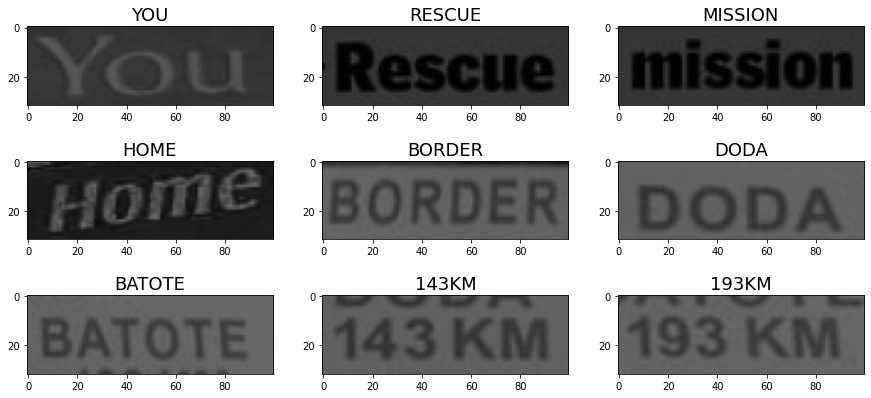

In [42]:
plot_examples(train_ds)

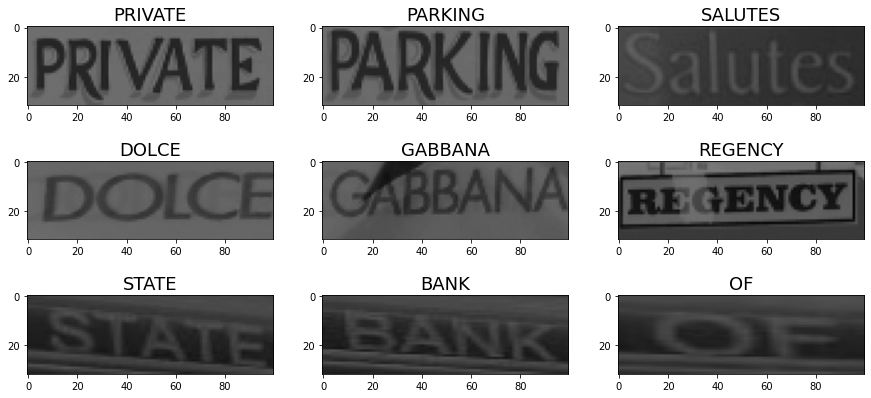

In [43]:
plot_examples(test_ds)

In [44]:
BATCH_SIZE = 256
LABELS_PADDING_CONST = -1

def configure_for_performance(dataset):    
    dataset = dataset.padded_batch(
        BATCH_SIZE,
        padding_values=(None, LABELS_PADDING_CONST),
        padded_shapes=(
            [datasets.IMAGE_HEIGHT, datasets.IMAGE_WIDTH, datasets.IMAGE_CHANNELS],
            [None],)
        )
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

In [45]:
def get_accuracy(model, dataset):
    accuracy = vit.metrics.CTCAccuracy()
    for X, y_true in dataset:
        y_pred = model.predict(X)
        y_pred = y_pred.argmax(axis=-1)
        y_pred[y_pred >= 36] -= 26
        y_pred = tf.one_hot(y_pred, 37)
        accuracy.update_state(y_true, y_pred)
    return accuracy.result().numpy()

In [46]:
model = tf.keras.models.load_model("saved_model")

In [47]:
get_accuracy(model, train_ds)

0.8545

In [48]:
get_accuracy(model, test_ds)

0.75766665